<a href="https://colab.research.google.com/github/foxtrotmike/CS909/blob/master/gmm_ecdf_time_normalise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Time-Adjusted Normalization of Multivariate Measurements**

Each patient $i$ has a **single measurement** $g_i \in \mathbb{R}^d$ recorded at a specific time $t_i$. Since measurement distributions change over time, we aim to transform all measurements to a **common reference time** $t^*$ using a transformation that matches both the mean and the covariance structure at the reference time.

## **Mathematical Formulation**

Let:
- $g_i$ be the measurement vector for patient $i$, recorded at time $t_i$
- $\mu_{t_i}$ and $\Sigma_{t_i}$ be the estimated **mean vector** and **covariance matrix** of $g$ at time $t_i$
- $\mu_{t^*}$ and $\Sigma_{t^*}$ be the mean and covariance at the **reference time** $t^*$
- $\Sigma_{t_i}^{-\frac{1}{2}}$ be the **whitening transform**, which removes the covariance structure at $t_i$
- $\Sigma_{t^*}^{\frac{1}{2}}$ be the **re-scaling transform**, which applies the covariance structure of the reference time $t^*$

The transformation to adjust $g_i$ to the reference time $t^*$ is given by:

$$
g_i^* = \Sigma_{t^*}^{\frac{1}{2}} \Sigma_{t_i}^{-\frac{1}{2}} (g_i - \mu_{t_i}) + \mu_{t^*}
$$

---

## **Explanation of Each Term**

1. **Center the Measurement**  
   $$g_i - \mu_{t_i}$$  
   This centers the measurement to remove the mean at $t_i$.

2. **Whitening Step**  
   $$\Sigma_{t_i}^{-\frac{1}{2}} (g_i - \mu_{t_i})$$  
   Removes the covariance structure of the distribution at $t_i$, resulting in uncorrelated, unit-variance variables.

3. **Re-scale to Reference Covariance**  
   $$\Sigma_{t^*}^{\frac{1}{2}} \Sigma_{t_i}^{-\frac{1}{2}} (g_i - \mu_{t_i})$$  
   Applies the covariance structure of the reference time $t^*$.

4. **Restore the Mean of Reference Time**  
   $$g_i^* = \Sigma_{t^*}^{\frac{1}{2}} \Sigma_{t_i}^{-\frac{1}{2}} (g_i - \mu_{t_i}) + \mu_{t^*}$$  
   Adds the reference mean to complete the transformation.

---

## **Special Cases**

### 1. **Diagonal Covariance Matrices (Uncorrelated Features)**

If $\Sigma_{t_i}$ and $\Sigma_{t^*}$ are diagonal (features are uncorrelated), then the transformation becomes a **feature-wise scaling**:

$$
g_i^* = \frac{g_i - \mu_{t_i}}{\sigma_{t_i}} \cdot \sigma_{t^*} + \mu_{t^*}
$$

where $\sigma_{t_i}$ and $\sigma_{t^*}$ are the standard deviations of the features at times $t_i$ and $t^*$, respectively.

### 2. **Scalar Case ($g_i$ is a single feature)**

If $g_i$ is 1D, then the formula reduces to:

$$
g_i^* = \frac{g_i - \mu_{t_i}}{\sigma_{t_i}} \cdot \sigma_{t^*} + \mu_{t^*}
$$

---

## **Intuition Behind the Adjustment**

- Each patient is observed only once, so we cannot model temporal trajectories per patient.
- However, we can estimate how the **distribution of measurements evolves over time** across the population.
- The transformation removes the effect of this time evolution, allowing for **time-harmonized comparison** across patients.


# **ECDF-Based Normalization of Multivariate Measurements**

Each patient $i$ has a **single measurement** $g_i \in \mathbb{R}^d$ recorded at a specific time $t_i$. Since measurement distributions change over time, we aim to transform all measurements to a **common probabilistic scale** using the **empirical cumulative distribution function (ECDF)** estimated from the training data.

## **Mathematical Formulation**

Let:
- $g_i$ be the measurement vector for patient $i$, recorded at time $t_i$.
- For each feature $j$, $g_i^{(j)}$ denotes the $j$-th component of $g_i$.
- $F_t^{(j)}(x)$ be the **empirical CDF** of feature $j$ at time $t$ computed from training data.

The normalized value of feature $j$ for patient $i$ is:

$$
g_i^{*(j)} = F_{t_i}^{(j)}\left(g_i^{(j)}\right)
$$

That is, each measurement is mapped to its **percentile** within the empirical distribution at the corresponding time and feature.

---

## **Explanation of Each Term**

1. **Empirical CDF per Time and Feature**

$$
F_t^{(j)}(x) = \frac{1}{n_t} \sum_{k=1}^{n_t} \mathbb{I}\left[x_k^{(j)} \leq x\right]
$$

Where:
- $x_k^{(j)}$ are the training values of feature $j$ at time $t$
- $n_t$ is the number of training samples at time $t$
- $\mathbb{I}[\cdot]$ is the indicator function

2. **Transformation of a New Measurement**

$$
g_i^{*(j)} = \frac{\#\{x_k^{(j)} \leq g_i^{(j)}\}}{n_t}
$$

This computes the percentile of $g_i^{(j)}$ within the training values at time $t_i$.

---

## **Properties of ECDF-Based Normalization**

- **Non-parametric**: No assumptions on data distribution.
- **Robust to outliers**: Based on ordering, not magnitude.
- **Monotonic**: Preserves order within each time group.
- **Standardized scale**: Maps values to $[0, 1]$.

---

## **Special Cases**

### 1. **Values Outside Training Range**

- If $g_i^{(j)} < \min(x_k^{(j)})$, then $g_i^{*(j)} = 0$
- If $g_i^{(j)} > \max(x_k^{(j)})$, then $g_i^{*(j)} = 1$

### 2. **Tied Values**

Multiple training values equal to $g_i^{(j)}$ are all counted in the ECDF, stabilizing the result.

### 3. **Single Training Value at $t$**

The ECDF becomes a step function:
- Values below → $0$
- Equal or above → $1$

---

## **Intuition Behind ECDF Normalization**

- Each patient is measured only once at time $t_i$, and the measurement distributions vary over time.
- ECDF normalization maps each value to its **relative standing** within its time group.
- This provides a **distribution-independent**, standardized view across time points, useful for modeling and visualization.


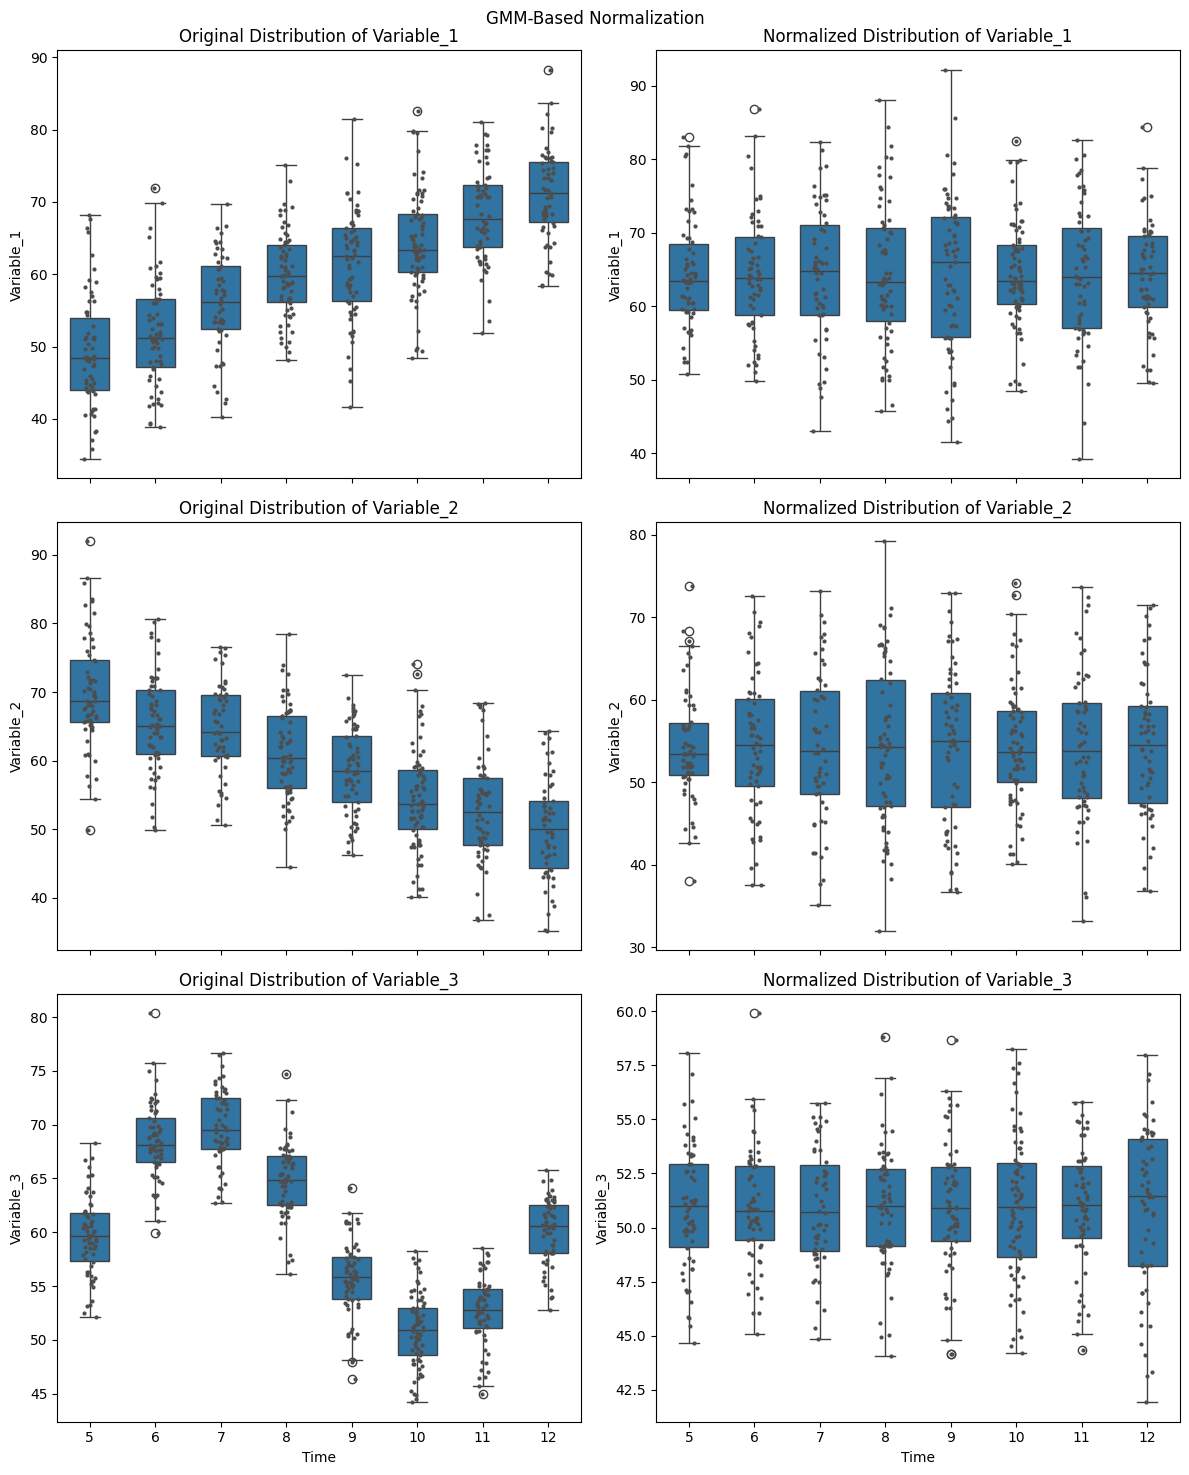

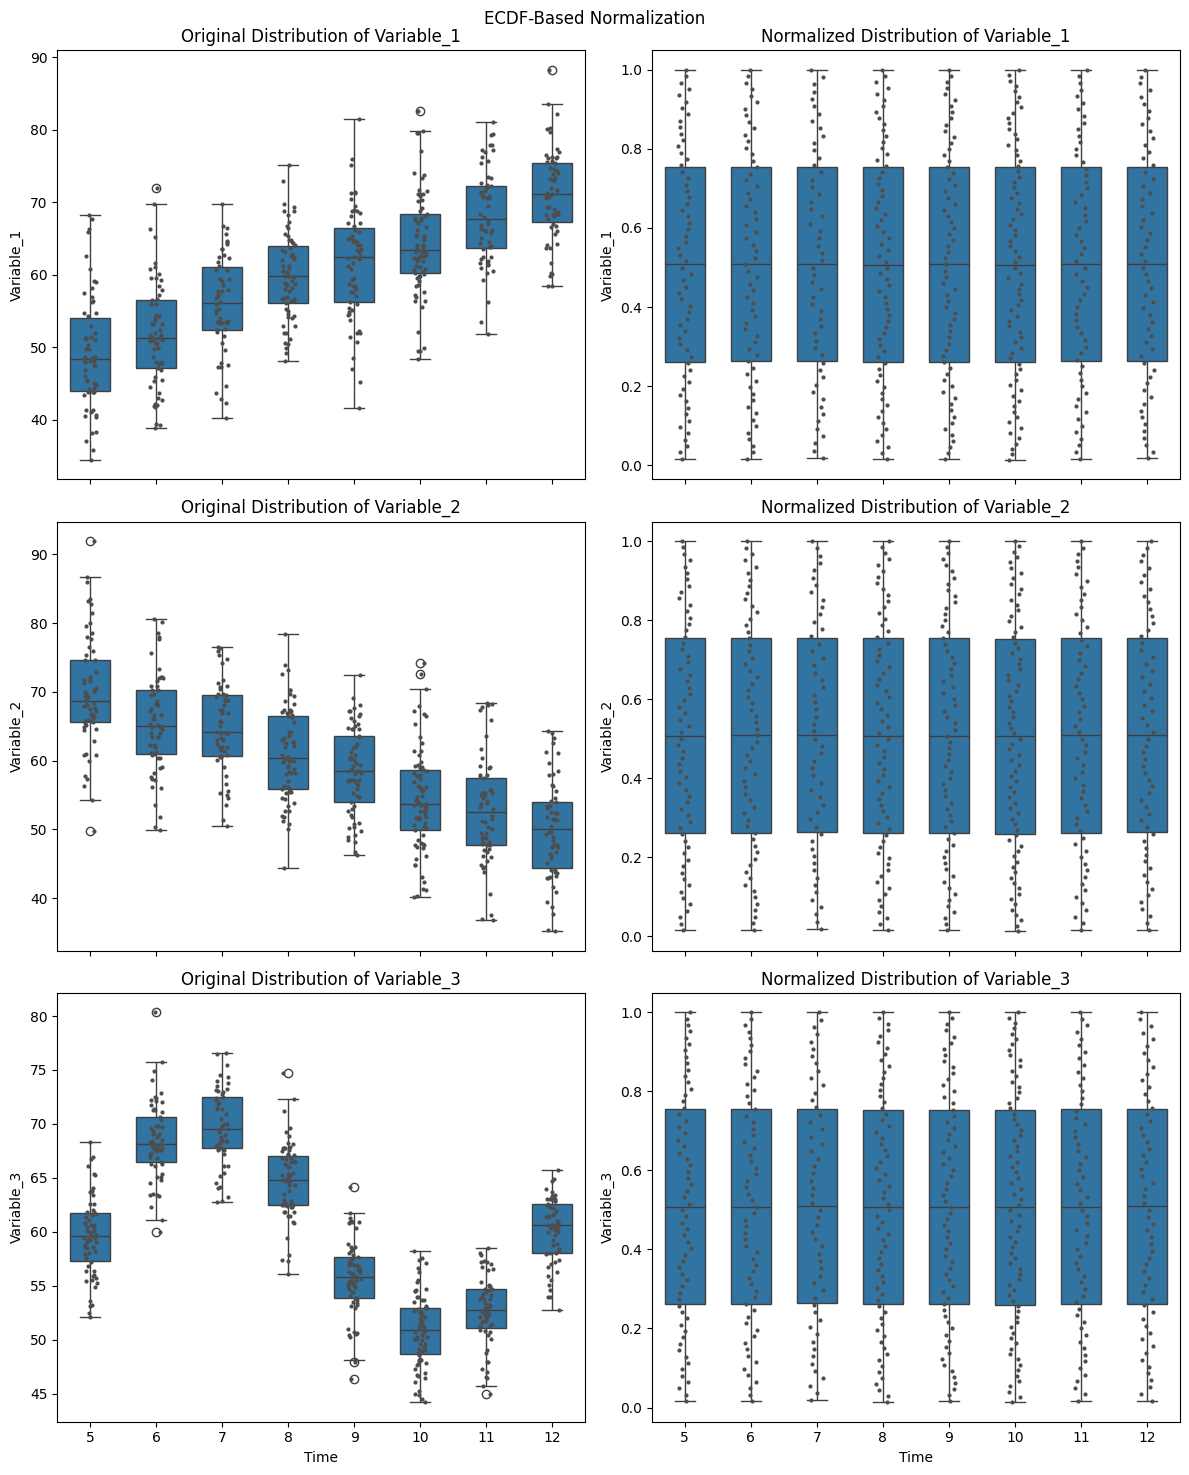

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from scipy.linalg import sqrtm, inv, cholesky
from scipy.stats import rankdata

# Set random seed for reproducibility
np.random.seed(42)

# ================================================
# 🚀 Step 1: Data Generator
# ================================================
class DataGenerator:
    def __init__(self, n_samples=500, time_points=None, dim=3, std_dev=None, correlation_matrix=None):
        self.n_samples = n_samples
        self.time_points = time_points if time_points is not None else np.array([5, 6, 7, 8, 9, 10, 11, 12])
        self.dim = dim
        self.std_dev = std_dev if std_dev is not None else np.array([5, 7, 6])
        self.correlation_matrix = correlation_matrix if correlation_matrix is not None else np.array([
            [1.0, 0.7, 0.0],
            [0.7, 1.0, -0.6],
            [0.0, -0.6, 1.0]
        ])
        self.cov_matrix = np.outer(self.std_dev, self.std_dev) * self.correlation_matrix

        # Define different mean trends for each variable
        self.mean_trends = [
            np.linspace(50, 70, len(self.time_points)),  # Variable 1: Increasing
            np.linspace(70, 50, len(self.time_points)),  # Variable 2: Decreasing
            60 + 10 * np.sin(np.linspace(0, 2 * np.pi, len(self.time_points)))  # Variable 3: Random fluctuations
        ]

    def generate_data(self):
        data = []
        for _ in range(self.n_samples):
            t = np.random.choice(self.time_points)  # Each sample has one time point
            t_index = list(self.time_points).index(t)

            # Assign different trends to each variable
            mu_t = np.array([self.mean_trends[i][t_index] for i in range(self.dim)])

            # Generate correlated random variables
            L = cholesky(self.cov_matrix)
            g_i = mu_t + L @ np.random.randn(self.dim)

            data.append([t] + list(g_i))

        columns = ["Time"] + [f"Variable_{i+1}" for i in range(self.dim)]
        df = pd.DataFrame(data, columns=columns)
        df["Time"] = df["Time"].astype(self.time_points.dtype)  # Ensure "Time" retains its original dtype
        return df


# ================================================
# 🚀 Step 2: Normalization Methods
# ================================================
class GMMNormalizer:
    """Gaussian Mixture Model-based normalization (to reference time)."""
    def __init__(self, ref_time=10, n_components=2):
        self.ref_time = ref_time
        self.n_components = n_components
        self.fitted_means = {}
        self.fitted_covs = {}
        self.time_dtype = None
        self.measurement_cols = []

    def fit(self, df):
        self.time_dtype = df["Time"].dtype
        self.measurement_cols = [col for col in df.columns if col != "Time"]
        time_points = sorted(df["Time"].unique())

        for t in time_points:
            subset = df[df["Time"] == t][self.measurement_cols].values
            gmm = GaussianMixture(n_components=self.n_components, random_state=42)
            gmm.fit(subset)

            weights = gmm.weights_
            means = gmm.means_
            covariances = gmm.covariances_

            weighted_mean = np.sum(weights[:, None] * means, axis=0)
            weighted_cov = np.sum(weights[:, None, None] * covariances, axis=0)

            self.fitted_means[t] = weighted_mean
            self.fitted_covs[t] = weighted_cov

    def transform(self, df):
        t_ref = self.ref_time
        mu_ref = self.fitted_means[t_ref]
        cov_ref = self.fitted_covs[t_ref]

        def normalize_row(row):
            t_i = row["Time"]
            mu_t = self.fitted_means[t_i]
            cov_t = self.fitted_covs[t_i]

            whitening = sqrtm(inv(cov_t))
            re_scale = sqrtm(cov_ref)

            x = row[self.measurement_cols].values
            x_norm = re_scale @ whitening @ (x - mu_t) + mu_ref

            return pd.Series([row["Time"]] + list(x_norm), index=["Time"] + self.measurement_cols)

        norm_df = df.apply(normalize_row, axis=1)
        norm_df["Time"] = norm_df["Time"].astype(self.time_dtype)
        return norm_df

    def fit_transform(self, df):
        self.fit(df)
        return self.transform(df)


class EmpiricalCDFNormalizer:
    """Empirical CDF Normalizer to transform values into percentiles."""
    def __init__(self):
        self.cdf_lookup = {}  # (time, column) -> sorted training values
        self.measurement_cols = []
        self.time_dtype = None

    def fit(self, df):
        self.measurement_cols = [col for col in df.columns if col != "Time"]
        self.time_dtype = df["Time"].dtype
        for t in df["Time"].unique():
            for col in self.measurement_cols:
                values = np.sort(df[df["Time"] == t][col].values)
                self.cdf_lookup[(t, col)] = values

    def transform(self, df):
        df = df.copy()
        for col in self.measurement_cols:
            def map_cdf(row):
                t = row["Time"]
                x = row[col]
                sorted_vals = self.cdf_lookup.get((t, col), None)
                if sorted_vals is None or len(sorted_vals) == 0:
                    return np.nan
                rank = np.searchsorted(sorted_vals, x, side="right")
                return rank / len(sorted_vals)

            df[col] = df.apply(map_cdf, axis=1)

        df["Time"] = df["Time"].astype(self.time_dtype)
        return df

    def fit_transform(self, df):
        self.fit(df)
        return self.transform(df)


# ================================================
# 🚀 Step 3: Plotting Function
# ================================================
def plot_box_strip(original_df, normalized_df, title="Comparison of Original and Normalized Data"):
    if "Time" not in original_df.columns or "Time" not in normalized_df.columns:
        raise KeyError("Both original and normalized data must have a 'Time' column.")

    dim = original_df.shape[1] - 1  # Exclude "Time" column
    fig, axes = plt.subplots(dim, 2, figsize=(12, 5 * dim), sharex=True)

    for i, col in enumerate(original_df.columns[1:]):  # Skip "Time" column
        # Original Distribution - Box + Strip Plot
        sns.boxplot(x="Time", y=col, data=original_df, ax=axes[i, 0], showfliers=True, width=0.6)
        sns.stripplot(x="Time", y=col, data=original_df, ax=axes[i, 0], jitter=True, size=3, color=".3")
        axes[i, 0].set_title(f"Original Distribution of {col}")
        axes[i, 0].set_ylabel(col)

        # Normalized Distribution - Box + Strip Plot
        norm_col = normalized_df.columns[i + 1]  # Adjusted for "Time" column in normalized_df
        sns.boxplot(x="Time", y=norm_col, data=normalized_df, ax=axes[i, 1], showfliers=True, width=0.6)
        sns.stripplot(x="Time", y=norm_col, data=normalized_df, ax=axes[i, 1], jitter=True, size=3, color=".3")
        axes[i, 1].set_title(f"Normalized Distribution of {col}")
        axes[i, 1].set_ylabel(norm_col)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()



# ================================================
# 🚀 Main Execution
# ================================================
if __name__ == "__main__":
    # Generate Data
    data_gen = DataGenerator()
    df = data_gen.generate_data()

    # Apply GMM Normalization
    gmm_normalizer = GMMNormalizer(ref_time=10)
    gmm_normalizer.fit(df)
    df_gmm_normalized = gmm_normalizer.transform(df)
    plot_box_strip(df, df_gmm_normalized, title="GMM-Based Normalization")

    # Apply ECDF Normalization
    ecdf_normalizer = EmpiricalCDFNormalizer()
    ecdf_normalizer.fit(df)
    df_ecdf_normalized = ecdf_normalizer.transform(df)
    plot_box_strip(df, df_ecdf_normalized, title="ECDF-Based Normalization")


In [24]:
ecdf_normalizer.cdf_lookup

{(np.int64(11),
  'Variable_1'): array([51.87752931, 53.53385251, 56.29817855, 59.26118391, 60.29762962,
        60.57263242, 60.96765035, 61.34019479, 61.45256137, 61.6556441 ,
        61.84390297, 62.14219983, 62.38015711, 62.49443476, 63.48458815,
        63.76030495, 63.81297724, 63.9268202 , 64.3784594 , 64.54292643,
        65.04269792, 65.69061086, 66.01710388, 66.13158931, 66.17028441,
        66.32434484, 66.42700885, 66.91730675, 67.04741537, 67.39163379,
        67.99770297, 68.32624454, 69.50046488, 70.63812989, 70.6479213 ,
        70.65151928, 70.7374254 , 70.79786193, 70.88830062, 71.09493366,
        71.45285837, 71.60416103, 71.89352843, 72.14580342, 72.24567295,
        72.36778774, 72.71807463, 73.32246571, 73.47598892, 75.33949321,
        75.68342032, 76.19164483, 76.95038049, 77.14693093, 77.22071013,
        77.85453554, 77.8979001 , 79.2859009 , 79.40757449, 81.02568624]),
 (np.int64(11),
  'Variable_2'): array([36.80582985, 37.02588836, 37.55219094, 40.60573361

In [20]:
df_ecdf_normalized

,Time,Variable_1,Variable_2,Variable_3
0,11,0.466667,0.516667,0.616667
1,6,0.918033,0.409836,0.770492
2,12,0.344828,0.500000,0.551724
3,6,0.491803,0.622951,0.229508
4,8,0.303030,0.560606,0.287879
...,...,...,...,...
495,12,0.120690,0.172414,0.603448
496,8,0.545455,0.818182,0.409091
497,9,0.830769,0.384615,0.876923
498,8,0.257576,0.727273,0.227273


In [ ]:
normalizer.fitted_means

In [ ]:
df_rank_normalized

# Legacy code below [Ignore]

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from scipy.linalg import sqrtm, inv, cholesky

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
n_patients = 500
time_points = np.array([0, 5, 10, 15, 20])  # Discrete time points
dim_g = 3  # Number of dimensions in g_i (adjustable)
std_dev = np.array([5, 7, 6])  # Different standard deviations per variable

# Define a base correlation matrix (should be positive definite)
base_corr = np.array([
    [1.0, 0.7, 0.5],  # Correlation between variables
    [0.7, 1.0, 0.6],
    [0.5, 0.6, 1.0]
])

# Convert to covariance matrix
cov_base = np.outer(std_dev, std_dev) * base_corr  # Σ = D * R * D

# Define time-dependent mean trends
mean_trend = np.linspace(50, 70, len(time_points))  # Mean change over time

# Simulate multivariate measurements (each patient has a single measurement at a given time)
data = []
for i in range(n_patients):
    t = np.random.choice(time_points)  # Each patient has ONE measurement at a single random time
    mu_t = np.array([mean_trend[list(time_points).index(t)] + i * 2 for i in range(dim_g)])

    # Generate correlated random variables using Cholesky decomposition
    L = cholesky(cov_base)  # Cholesky factorization for correlation structure
    g_i = mu_t + L @ np.random.randn(dim_g)  # Apply correlated structure

    data.append([t] + list(g_i))

# Create DataFrame
columns = ["Time"] + [f"Measurement_{i+1}" for i in range(dim_g)]
df = pd.DataFrame(data, columns=columns)

# Fit Multivariate GMMs at each time point
n_components = 2  # Assume 2 subpopulations per time point
fitted_means = {}
fitted_covs = {}

for t in time_points:
    subset = df[df["Time"] == t].iloc[:, 1:].values  # Extract measurement columns
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(subset)

    # Compute the weighted mean and covariance
    weights = gmm.weights_
    means = gmm.means_
    covariances = gmm.covariances_

    weighted_mean = np.sum(weights[:, None] * means, axis=0)
    weighted_cov = np.sum(weights[:, None, None] * covariances, axis=0)

    fitted_means[t] = weighted_mean
    fitted_covs[t] = weighted_cov

# Choose reference time (e.g., time = 10)
t_ref = 10
mu_ref = fitted_means[t_ref]
cov_ref = fitted_covs[t_ref]

# Normalize measurements for all dimensions
def normalize_multivariate(row):
    t_i = row["Time"]
    mu_t = fitted_means[t_i]
    cov_t = fitted_covs[t_i]

    # Whitening transform
    whitening_transform = sqrtm(inv(cov_t))
    re_scaling_transform = sqrtm(cov_ref)

    g_original = np.array(row.iloc[1:])  # Extract measurement vector
    g_transformed = re_scaling_transform @ whitening_transform @ (g_original - mu_t) + mu_ref

    return pd.Series(g_transformed)

# Apply normalization
normalized_columns = [f"Normalized Measurement_{i+1}" for i in range(dim_g)]
df[normalized_columns] = df.apply(normalize_multivariate, axis=1)

# Plot original and normalized distributions for each measurement variable
fig, axes = plt.subplots(dim_g, 2, figsize=(12, 5 * dim_g), sharex=True)

for i in range(dim_g):
    measurement_col = f"Measurement_{i+1}"
    normalized_col = f"Normalized Measurement_{i+1}"

    # Original distribution
    sns.violinplot(x="Time", y=measurement_col, data=df, ax=axes[i, 0], inner="quartile")
    axes[i, 0].set_title(f"Original Distribution of {measurement_col}")
    axes[i, 0].set_ylabel(measurement_col)

    # Normalized distribution
    sns.violinplot(x="Time", y=normalized_col, data=df, ax=axes[i, 1], inner="quartile")
    axes[i, 1].set_title(f"Normalized Distribution of {normalized_col} (Adjusted to Time {t_ref})")
    axes[i, 1].set_ylabel(normalized_col)

plt.tight_layout()
plt.show()


In [ ]:
#Using OT - ignore for now
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ot  # POT: Python Optimal Transport

# Generate synthetic data
np.random.seed(42)
n_patients = 500
time_points = np.array([0, 5, 10, 15, 20])
dim_g = 2  # Number of dimensions in g_i

# Simulate multivariate measurements (patients measured only once at random time points)
data = []
for i in range(n_patients):
    t = np.random.choice(time_points)
    mu_t = np.array([50 + (t / 2) + i * 0.5 for i in range(dim_g)])  # Time-dependent mean
    cov_t = np.eye(dim_g) * 5  # Independent feature variance
    g_i = np.random.multivariate_normal(mu_t, cov_t)
    data.append([t] + list(g_i))

df = pd.DataFrame(data, columns=["Time"] + [f"Measurement_{i+1}" for i in range(dim_g)])

# Select a reference time (e.g., t=10)
t_ref = 10
source_data = df[df["Time"] == t_ref].iloc[:, 1:].values  # Target distribution

# Ensure proper mapping of transported data
transformed_data = df.copy()

for t in time_points:
    if t == t_ref:
        continue  # Skip reference time since we normalize everything to it

    # Extract data for the current time
    target_data = df[df["Time"] == t].iloc[:, 1:].values

    if len(target_data) == 0:
        continue  # Skip if no data for this time

    # Compute cost matrix (Euclidean distance)
    cost_matrix = ot.dist(target_data, source_data, metric="euclidean")

    # Define uniform weights for both distributions
    n_source, n_target = len(source_data), len(target_data)
    a, b = np.ones(n_target) / n_target, np.ones(n_source) / n_source  # Equal weights

    # Compute Optimal Transport plan
    transport_plan = ot.emd(a, b, cost_matrix)  # Solve OT problem

    # Compute transported samples via Barycentric Projection
    mapped_data = transport_plan @ source_data  # Move target data towards reference

    # Directly replace transformed data without additional standardization
    transformed_data.loc[df["Time"] == t, df.columns[1:]] = mapped_data

# Plot original and normalized distributions
fig, axes = plt.subplots(dim_g, 2, figsize=(12, 5 * dim_g), sharex=True)

for i in range(dim_g):
    measurement_col = f"Measurement_{i+1}"

    sns.violinplot(x="Time", y=measurement_col, data=df, ax=axes[i, 0], inner="quartile")
    axes[i, 0].set_title(f"Original Distribution of {measurement_col}")

    sns.violinplot(x="Time", y=measurement_col, data=transformed_data, ax=axes[i, 1], inner="quartile")
    axes[i, 1].set_title(f"Normalized Distribution of {measurement_col} (Adjusted to Time {t_ref})")

plt.tight_layout()
plt.show()